## Clasificación de Textos

<img src="figs/fig-diagrama-clasificador.png" width="900">

# Entrenamiento del clasificador

# 1. Cargar el conjunto de datos

In [1]:
# Normalización del texto

import unicodedata
import re
PUNCTUACTION = ";:,.\\-\"'/"
SYMBOLS = "()[]¿?¡!{}~<>|"
NUMBERS= "0123456789"
SKIP_SYMBOLS = set(PUNCTUACTION + SYMBOLS)
SKIP_SYMBOLS_AND_SPACES = set(PUNCTUACTION + SYMBOLS + '\t\n\r ')

def normaliza_texto(input_str,
                    punct=False,
                    accents=False,
                    num=False,
                    max_dup=2):
    """
        punct=False (elimina la puntuación, True deja intacta la puntuación)
        accents=False (elimina los acentos, True deja intactos los acentos)
        num= False (elimina los números, True deja intactos los acentos)
        max_dup=2 (número máximo de símbolos duplicados de forma consecutiva, rrrrr => rr)
    """
    
    nfkd_f = unicodedata.normalize('NFKD', input_str)
    n_str = []
    c_prev = ''
    cc_prev = 0
    for c in nfkd_f:
        if not num:
            if c in NUMBERS:
                continue
        if not punct:
            if c in SKIP_SYMBOLS:
                continue
        if not accents and unicodedata.combining(c):
            continue
        if c_prev == c:
            cc_prev += 1
            if cc_prev >= max_dup:
                continue
        else:
            cc_prev = 0
        n_str.append(c)
        c_prev = c
    texto = unicodedata.normalize('NFKD', "".join(n_str))
    texto = re.sub(r'(\s)+', r' ', texto.strip(), flags=re.IGNORECASE)
    return texto



In [3]:
import pandas as pd
dataset = pd.read_json("./data/data_emotions_es.json", lines=True)
X = dataset['text'].to_numpy()
Y = dataset['klass'].to_numpy()

dataset.groupby(['klass']).count()

,id,text,intensity
klass,,,
anger,800,800,800
fear,800,800,800
joy,800,800,800
sadness,800,800,800


## 2. Preparar los conjuntos de datos  (datasets) para entrenamiento y para probar el rendimiento del clasificador

In [4]:
# Dividir el conjunto de datos en conjunto de entrenamiento (80%) y conjunto de pruebas (20%)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Normalizar las etiquetas a una codificación ordinal para entrada del clasificador
Y_encoded= le.fit_transform(Y)


X_train, X_test, Y_train, Y_test =  train_test_split(X, Y_encoded, test_size=0.2, stratify=Y_encoded, random_state=42)


## 3. Creación de la matriz de pesos 

In [5]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize

_STOPWORDS = stopwords.words("spanish")
# Preprocesamiento personalizado 
def mi_preprocesamiento(texto):
    #convierte a minúsculas el texto antes de normalizar
    tokens = word_tokenize(texto.lower())
    texto = " ".join(tokens)
    texto = normaliza_texto(texto)
    return texto
    
# Tokenizador personalizado 
def mi_tokenizador(texto):
    # Elimina stopwords 
    return [t for t in texto.split() if t not in _STOPWORDS]


vec_tfidf = TfidfVectorizer(analyzer="word", preprocessor=mi_preprocesamiento, tokenizer=mi_tokenizador,  ngram_range=(1,1))
X_tfidf = vec_tfidf.fit_transform(X_train)
print("tamaño de la matriz: ", X_tfidf.shape)
print("vocabulario: ", len(vec_tfidf.get_feature_names_out()))


/Users/admin/opt/anaconda3/envs/taller_nlp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


tamaño de la matriz:  (2560, 7573)
vocabulario:  7573


## 4. Convierte los ejemplos de prueba al mismo espacio de representación de datos del conjunto de entrenamiento que aprendió el modelo

In [6]:

X_test_tfidf = vec_tfidf.transform(X_test)


# 5. Entrenar al clasificador

### Clasificador: Support Vector Machine (SVM)

- ### El **Método de Máquinas de Vectores de Soporte (SVM, por sus siglas en inglés)** 
    - #### Es un algoritmo de aprendizaje supervisado utilizado para clasificación y regresión. 
    - #### Su objetivo principal es encontrar un hiperplano en un espacio de características que maximice el margen entre diferentes clases de datos.

- ### Funcionamiento:

    1. **Clasificación**: 
        - SVM busca el hiperplano que mejor separa las diferentes clases de datos con el mayor margen posible. 
        - Los puntos de datos que están más cerca del hiperplano se llaman vectores de soporte, ya que definen el margen de separación.

    2. **Regresión**: 
        - En el caso de regresión, SVM intenta encontrar un hiperplano que se ajuste a los datos de manera que la desviación entre las predicciones y los valores reales sea mínima.

- ### Características Clave:

    - **Hiperplano Óptimo**: Maximiza la distancia entre el hiperplano y los vectores de soporte. En la fig. H3 maximiza el margen
    - **Espacio de Características**: Puede utilizar el truco del núcleo (kernel trick) para transformar los datos en un espacio de dimensiones más altas, facilitando la separación no lineal.
    - **Regularización**: Controla el equilibrio entre el margen máximo y la clasificación correcta de los datos de entrenamiento.



<center>
<img src="figs/fig-svm.png" width="300" style="background-color:white;">
</center>

###### Fuente: https://es.wikipedia.org/wiki/Máquinas_de_vectores_de_soporte


### Importamos LinearSVC del paquete sklearn

In [7]:
from sklearn.svm import LinearSVC

clasificador_svc = LinearSVC(random_state=42)

# Entrenamos al clasificador

clasificador_svc.fit(X_tfidf, Y_train)


LinearSVC(random_state=42)

### Predicción de los datos del conjuntos de prueba con el modelo entrenado

In [8]:
y_pred = clasificador_svc.predict(X_test_tfidf)


### Inspección de los resultados de los primeros N ejemplos de prueba

In [9]:
print("textos: ", X_test[:5])
print("clase esperada: ",Y_test[:5])
print("clase predicha: ", y_pred[:5])

textos:  ['Espiritu chocarreros del WP se nos metio en el GRUPO '
 'woa extrañar hablar con mi persona fav y no twittear gracias a que esta tonta perdió su adaptador >:v'
 '#SelenasNewSingleOutNow he escuchado una parte de fetish y es re hermosa, voy a morir de la desesperación ahr'
 'Que nervioso me hizo poner hoy la vieja esa en la escuela jajajajaja'
 'Taiga se enojo.']
clase esperada:  [1 3 1 1 0]
clase predicha:  [2 3 1 1 3]


### Mostrar la predicción de la clase original 

In [10]:
# Obten las primeras N predicciones
pred =  y_pred[:5] 
pred_ori = le.inverse_transform(pred)
pred, pred_ori

(array([2, 3, 1, 1, 3]),
 array(['joy', 'sadness', 'fear', 'fear', 'sadness'], dtype=object))

# 6. Evaluando el desempeño

## Métricas de Evaluación
 - #### Las métricas precisión, recall y F1 son fundamentales para evaluar el rendimiento de un clasificador


<img src="figs/fig_precision-recall.png" width="300">

##### Fuente: https://en.wikipedia.org/wiki/Precision_and_recall


<img src="figs/fig_matriz-confusion.png" width="500">


TP=True Positive

TN=True Negative

FP=False Positive (Error tipo I: ejemplo, se considera que el paciente está enfermo, pero en realidad está sano)

FN=False Negative ( Error tipo II: ejemplo, se considera que el paciente está sano, pero en realidad está enfermo)


$$ Accuracy = \frac{total~ TP + total~TN}{total~muestras} $$

$$ Precision_c = \frac{ TP_c}{TP_c + FP_c} $$

$$ Recall_c = \frac{ TP_c}{TP_c + FN_c} $$

$$ F1-score_c= 2 \times \frac{ Precision_c \times Recall_c}{Precision_c + Recall_c} $$

$$ macro-F1-score= \frac{ 1 }{|Clases|} \sum{F1-score_c} $$

## Matriz de confusión

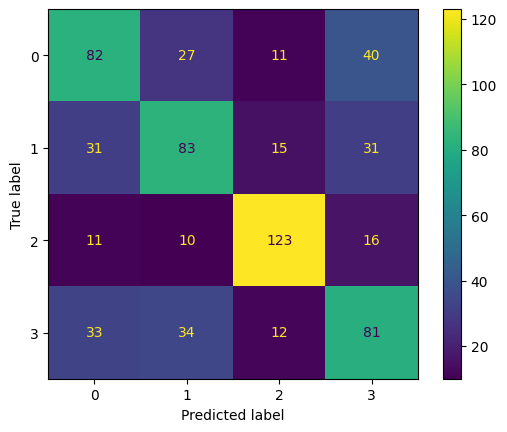

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_test, y_pred)

In [12]:
# para la clase 0, la precisión es la siguiente
tp= 82
fp = 31+11+33
tp/(tp + fp)

0.5222929936305732

## Métricas

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print("P=", precision_score(Y_test, y_pred, average='macro'))
print("R=", recall_score(Y_test, y_pred, average='macro'))
print("F1=", f1_score(Y_test, y_pred, average='macro'))
print("Acc=", accuracy_score(Y_test, y_pred))


P= 0.5768430112534931
R= 0.5765625
F1= 0.5765675393305445
Acc= 0.5765625


## Inspección del desempeño por clase

In [14]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, y_pred))

[[ 82  27  11  40]
 [ 31  83  15  31]
 [ 11  10 123  16]
 [ 33  34  12  81]]


In [15]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred, digits=4, zero_division='warn'))

              precision    recall  f1-score   support

           0     0.5223    0.5125    0.5174       160
           1     0.5390    0.5188    0.5287       160
           2     0.7640    0.7688    0.7664       160
           3     0.4821    0.5062    0.4939       160

    accuracy                         0.5766       640
   macro avg     0.5768    0.5766    0.5766       640
weighted avg     0.5768    0.5766    0.5766       640



## 7. Guadar el modelo para despliegue de la aplicación

### Se recomienda generar un módulo para el despliegue del modelo (Por ejemplo clasificadorTODO.py)

In [17]:

from clasificadorTODO import ClasificadorTODO
import pickle

import pandas as pd
# Dividir el conjunto de datos en conjunto de entrenamiento (80%) y conjunto de pruebas (20%)
from sklearn.model_selection import train_test_split

dataset = pd.read_json("./data/data_emotions_es.json", lines=True)
X = dataset['text'].to_numpy()
Y = dataset['klass'].to_numpy()

le = LabelEncoder()
# Normalizar las etiquetas a una codificación ordinal para entrada del clasificador
Y_encoded= le.fit_transform(Y)

X_train, X_test, Y_train, Y_test =  train_test_split(X, Y_encoded, test_size=0.2, stratify=Y_encoded, random_state=42)

clasificador_svc = ClasificadorTODO()
clasificador_svc.setLabelEncoder(le)
clasificador_svc.fit(X_train, Y_train)


# guardar el modelo de clasificación
with open('./modelo_svc.pkl','wb') as file:
    pickle.dump(clasificador_svc, file)
    
print(clasificador_svc.predict([X_test[0]]))

Inicio de entrenamiento
Construyendo del modelo de representación del texto con los datos de entrenamiento
Fin de entrenamiento
Prediciendo nuevos datos
None


In [18]:

from clasificador import Clasificador
import pickle

import pandas as pd
# Dividir el conjunto de datos en conjunto de entrenamiento (80%) y conjunto de pruebas (20%)
from sklearn.model_selection import train_test_split

dataset = pd.read_json("./data/data_emotions_es.json", lines=True)
X = dataset['text'].to_numpy()
Y = dataset['klass'].to_numpy()

le = LabelEncoder()
# Normalizar las etiquetas a una codificación ordinal para entrada del clasificador
Y_encoded= le.fit_transform(Y)

X_train, X_test, Y_train, Y_test =  train_test_split(X, Y_encoded, test_size=0.2, stratify=Y_encoded, random_state=42)

clasificador_svc = Clasificador()
clasificador_svc.setLabelEncoder(le)
clasificador_svc.fit(X_train, Y_train)

# guardar el modelo de clasificación
with open('./modelo_svc.pkl','wb') as file:
    pickle.dump(clasificador_svc, file)
    
#Probando que el clasificador funcione correctamente

print(clasificador_svc.predict([X_test[0]]))

inicio de entrenamiento
Vectorizando datos de entrenamiento


/Users/admin/opt/anaconda3/envs/taller_nlp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fin de entrenamiento
Vectorizando texto
['Espiritu chocarreros del WP se nos metio en el GRUPO ']
['joy']
